In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.io
import torch
import glob
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
import shutil, os
from torchvision.utils import make_grid
import random


In [4]:
detector_npixels= 2304
detector_pixelsize= 6.5e-6
detector_side_len = detector_npixels * detector_pixelsize

magnification= 60

light_side_len= detector_side_len/ magnification
print(f'light_side_len : {light_side_len} m')
#light_pixelsize= 275e-9

d2nn_pixelsize= 3.164e-7 #for VisibleWavelengthD2NN
new_img_side_len= round(light_side_len/ d2nn_pixelsize)
print(f'new img size: {new_img_side_len} pixels')

### Problem : light_side_len (250um) != 225um (given in the description) !!!

light_side_len : 0.0002496 m
new img size: 789 pixels


In [5]:
def find_data_range(mat_files, type_, new_img_side_len):
    corrupted_mat_files= []
    
    maxs_abs, mins_abs= [], []
    maxs_phase, mins_phase= [], []
    
    for file_dir in mat_files:
        try:mat = scipy.io.loadmat(file_dir)
        except:
            corrupted_mat_files.append(file_dir)
            continue
        
        amp_img= np.real(mat['E_field'])
        phase_img= np.imag(mat['E_field'])
        
        amp_img = cv2.resize(amp_img, (new_img_side_len, new_img_side_len))
        phase_img = cv2.resize(phase_img, (new_img_side_len, new_img_side_len))

        maxs_abs.append(amp_img.max())
        mins_abs.append(amp_img.min())
        
        maxs_phase.append(phase_img.max())
        mins_phase.append(phase_img.min())
    print(f'\n{type_} --- AMP   ---> max: {np.round(np.max(maxs_abs), 10)} | min : {np.round(np.min(mins_abs), 10)}')
    print(f'{type_} --- PHASE ---> max: {np.round(np.max(maxs_phase), 10)} | min : {np.round(np.min(mins_phase), 10)} \n')
    
    if len(corrupted_mat_files)>0:
        corr_files= '\n'.join(corrupted_mat_files)
        print(f'corrupted mat files : \n {corr_files}')
        
def save_files(mat_dirs, type_, new_img_side_len, global_max= 1):
    try:shutil.rmtree(f'{save_dir}/{type_}')
    except:pass
    os.mkdir(f'{save_dir}/{type_}')

    corrupted_mat_files= []
    
    for i, file_dir in enumerate(mat_dirs):
        if i%10==0:print(f'dataset is creating -- {type_} --> {i}/ {len(mat_dirs)} images are created')
        
        try:mat = scipy.io.loadmat(file_dir)
        except:
            corrupted_mat_files.append(file_dir)
            continue
            
        amp_img= np.real(mat['E_field'])
        phase_img= np.imag(mat['E_field'])

        amp_img = cv2.resize(amp_img/global_max, (new_img_side_len, new_img_side_len))
        phase_img = cv2.resize(phase_img, (new_img_side_len, new_img_side_len))

        img_id = int(file_dir.split('_')[-1][:-4])
        save_file_dir= f'{save_dir}/{type_}/{img_id}.npy'
        np.save(save_file_dir, np.array([amp_img, phase_img]))
        
    if len(corrupted_mat_files)>0:
        corr_files= '\n'.join(corrupted_mat_files)
        print(f'corrupted mat files : \n {corr_files}')

In [6]:
#%cd '/n/holylabs/LABS/wadduwage_lab/Lab/QPM_HeLa_cells/'
#!unzip './raw.zip'
#%cd '/n/home06/udithhaputhanthri/data_generation_scripts'

raw_dir= '/n/holylabs/LABS/wadduwage_lab/Lab/QPM_HeLa_cells/raw' #/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_zip/raw
sorted_mat_dirs = sorted(glob.glob(f'{raw_dir}/*/*.mat'), key= lambda x: int(x.split('/')[-1].split('_')[-1][:-4]))
random.Random(4).shuffle(sorted_mat_dirs)

val_mat_files = sorted_mat_dirs[0:int(len(sorted_mat_dirs)*0.1)]
test_mat_files = sorted_mat_dirs[int(len(sorted_mat_dirs)*0.1):int(len(sorted_mat_dirs)*0.2)]
train_mat_files = sorted_mat_dirs[int(len(sorted_mat_dirs)*0.2):]

In [7]:
len(sorted_mat_dirs)

503

In [8]:
#find_data_range(train_mat_files, 'train', new_img_side_len)
#find_data_range(val_mat_files, 'val', new_img_side_len)
#find_data_range(test_mat_files, 'test', new_img_side_len)

'''
train --- AMP   ---> max: 0.0012528334 | min : 1.6699e-06
train --- PHASE ---> max: 97.0636352695 | min : -19.9971882587 

corrupted mat files : 
 /n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_zip/raw/Field_003-150/Field_135.mat
/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_zip/raw/Field_151-300/Field_175.mat

val --- AMP   ---> max: 0.0011544811 | min : 4.8506e-06
val --- PHASE ---> max: 21.767501406 | min : -5.9559540305 


test --- AMP   ---> max: 0.0011190413 | min : 4.1948e-06
test --- PHASE ---> max: 31.2796045295 | min : -7.2533026476 
'''

'\ntrain --- AMP   ---> max: 0.0012528334 | min : 1.6699e-06\ntrain --- PHASE ---> max: 97.0636352695 | min : -19.9971882587 \n\ncorrupted mat files : \n /n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_zip/raw/Field_003-150/Field_135.mat\n/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_zip/raw/Field_151-300/Field_175.mat\n\nval --- AMP   ---> max: 0.0011544811 | min : 4.8506e-06\nval --- PHASE ---> max: 21.767501406 | min : -5.9559540305 \n\n\ntest --- AMP   ---> max: 0.0011190413 | min : 4.1948e-06\ntest --- PHASE ---> max: 31.2796045295 | min : -7.2533026476 \n'

In [9]:
global_max= 0.0012528335 #
#save_dir= './to_delete'
save_dir= '/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_np_v4_CorrectScale'

!rm -rf '/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_np_v4_CorrectScale'
!mkdir '/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_np_v4_CorrectScale'

save_files(train_mat_files, 'train', new_img_side_len, global_max)
save_files(val_mat_files, 'val', new_img_side_len, global_max)
save_files(test_mat_files, 'test', new_img_side_len, global_max)

dataset is creating -- train --> 0/ 403 images are created
dataset is creating -- train --> 10/ 403 images are created
dataset is creating -- train --> 20/ 403 images are created
dataset is creating -- train --> 30/ 403 images are created
dataset is creating -- train --> 40/ 403 images are created
dataset is creating -- train --> 50/ 403 images are created
dataset is creating -- train --> 60/ 403 images are created
dataset is creating -- train --> 70/ 403 images are created
dataset is creating -- train --> 80/ 403 images are created
dataset is creating -- train --> 90/ 403 images are created
dataset is creating -- train --> 100/ 403 images are created
dataset is creating -- train --> 110/ 403 images are created
dataset is creating -- train --> 120/ 403 images are created
dataset is creating -- train --> 130/ 403 images are created
dataset is creating -- train --> 140/ 403 images are created
dataset is creating -- train --> 150/ 403 images are created
dataset is creating -- train --> 16

## Verify Datasets

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt

save_dir= '/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_np_v4_CorrectScale'


np_image_paths = sorted(glob.glob(f'{save_dir}/train/*.npy')) + sorted(glob.glob(f'{save_dir}/val/*.npy')) + sorted(glob.glob(f'{save_dir}/test/*.npy'))

inverted= [13, 72, 83, 127, 243, 273, 277, 312, 461, 14, 15, 242]
not_inverted = [int(x.split('/')[-1][:-4]) not in inverted for x in np_image_paths]
np_image_paths = np.array(np_image_paths)[not_inverted]

In [3]:
amp_imgs, phase_imgs= [], []
for index in range(len(np_image_paths)):
    amp_img, phase_img = np.load(np_image_paths[index])
    
    amp_imgs.append(amp_img)
    phase_imgs.append(phase_img)
amp_imgs= np.array(amp_imgs)
phase_imgs= np.array(phase_imgs)

In [16]:
amp_imgs.shape, phase_imgs.shape, phase_imgs.max()

((489, 789, 789), (489, 789, 789), 97.06363526954051)

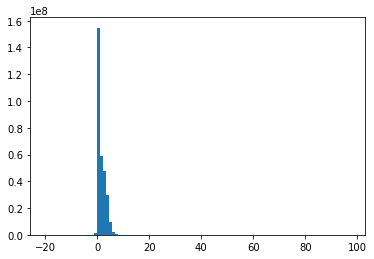

In [15]:
_= plt.hist(phase_imgs.flatten(), bins= 100)

In [5]:
#sorted_phase= sorted(phase_imgs.flatten())
#sorted_phase = np.array(sorted_phase)

In [20]:
(1- (np.clip(phase_imgs, 0, 2*np.pi) == phase_imgs).mean())*100

2.372410665861391

In [ ]:
%load_ext autoreload
%autoreload 2

from OpticalElectronicQPI.training.qpm_datasets_correctScale import qpm_np_v4_CorrectedScale
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
data_dir= '/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_np_v4_CorrectScale'
type_ = 'test'
crop_size= 256

In [ ]:
dataset = qpm_np_v4_CorrectedScale(data_dir, type_= type_, crop_size= crop_size)

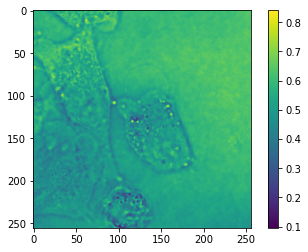

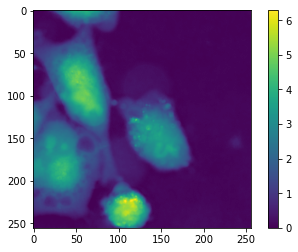

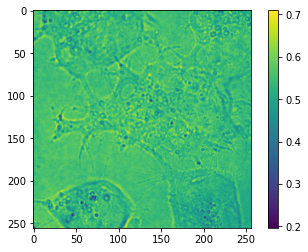

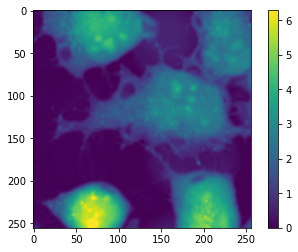

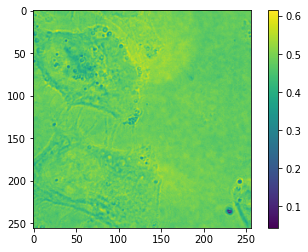

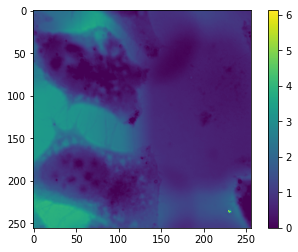

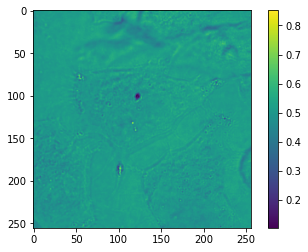

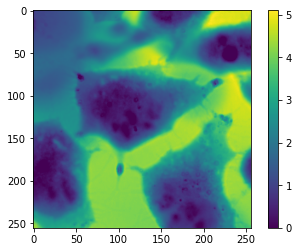

In [25]:
loader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4, drop_last=True)

for i, out in enumerate(loader):
    if i>3:break
    plt.imshow(out.abs()[2,0])
    plt.colorbar()
    plt.show()

    plt.imshow(out.angle()[2,0]% (2*np.pi))
    plt.colorbar()
    plt.show()


In [6]:
import os

len(os.listdir('/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_np_v4_CorrectScale/train')), len(os.listdir('/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_np_v4_CorrectScale/val')), len(os.listdir('/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_np_v4_CorrectScale/test'))

(401, 50, 50)

In [28]:
## checking for duplicate images

In [30]:
data_dir= '/n/holyscratch01/wadduwage_lab/D2NN_QPM_microscopy/datasets/qpm_np_v4_CorrectScale'


In [47]:
import glob
img_dirs = glob.glob(f'{data_dir}/*/*.npy')
print(f'1 - tot img dirs : {len(img_dirs)}')

random_idx = np.random.randint(0, len(img_dirs))
print(f'selected random sample idx : {random_idx}')
random_sample = np.load(img_dirs[random_idx])

img_dirs = list(img_dirs[:random_idx]) + list(img_dirs[random_idx+1:])
print(f'2 - tot img dirs : {len(img_dirs)}')

duplicate_found= 0
for img_dir in img_dirs:
    selected_sample = np.load(img_dir)
    if (selected_sample == random_sample).all():
        duplicate_found += 1
        print(f'DUPLICATE FOUND !!!! -> tot duplicates: {duplicate_found}')

if duplicate_found== 0:print('NO DUPLICATES !!!')

1 - tot img dirs : 501
selected random sample idx : 376
2 - tot img dirs : 500
NO DUPLICATES !!!
